In [23]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import sys
import random
from keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt #для рисования графиков

In [14]:
filename = "wonderland.txt"
raw_text = open(filename).read()
raw_text = raw_text.lower()
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [15]:
n_chars = len(raw_text)
n_vocab = len(chars)
print( "Total Characters: ", n_chars)
print( "Total Vocab: ", n_vocab)
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Characters:  77220
Total Vocab:  51
Total Patterns:  77120


In [17]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [18]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy',
optimizer='adam')

In [19]:
class TextGenerationCallback(Callback):
    def __init__(self, chars, char_to_int, model, seq_length):
        self.chars = chars
        self.char_to_int = char_to_int
        self.model = model
        self.seq_length = seq_length
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0 and epoch!=0 :
            start = random.randint(0, len(raw_text) - self.seq_length - 1)
            pattern = [self.char_to_int[char] for char in raw_text[start:start + self.seq_length]]
            
            generated_text = ''
            for i in range(500):
                x = numpy.reshape(pattern, (1, self.seq_length, 1))
                x = x / float(len(self.chars))
                prediction = self.model.predict(x, verbose=0)
                index = numpy.argmax(prediction)
                result = self.chars[index]
                generated_text += result
                pattern.append(index)
                pattern = pattern[1:len(pattern)]
                
            print('Generated Text:')
            print(generated_text)

TextGenerationCallback предтсавляет собой класс (CallBack), который добавляется в список callbacks_list и имеет метод,  on_epoch_end,вызывающийся после завершения каждой эпохи. В методе проверятся, что эпоха кратна 5 и не является нулевой, если условия соблюдаются, то на экран выводится текст сгенерированный моделью на данном этапе обучения.

In [20]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, TextGenerationCallback(chars, char_to_int, model, seq_length),[tensorboard]]


В список callbacks_list добавлен tensorboard, который собирает информацию о процессе обучения нейросети и записывает её в файл, котррый в дальнейшем можно просмотреть

In [21]:
data=model.fit(X, y, epochs=20, batch_size=128,callbacks=callbacks_list)

Epoch 1/20
603/603 [==============================] - ETA: 0s - loss: 3.1370
Epoch 1: loss improved from inf to 3.13697, saving model to weights-improvement-01-3.1370.hdf5
603/603 [==============================] - 228s 373ms/step - loss: 3.1370
Epoch 2/20
603/603 [==============================] - ETA: 0s - loss: 2.9244
Epoch 2: loss improved from 3.13697 to 2.92435, saving model to weights-improvement-02-2.9244.hdf5
603/603 [==============================] - 249s 413ms/step - loss: 2.9244
Epoch 3/20
603/603 [==============================] - ETA: 0s - loss: 2.7486
Epoch 3: loss improved from 2.92435 to 2.74862, saving model to weights-improvement-03-2.7486.hdf5
603/603 [==============================] - 254s 422ms/step - loss: 2.7486
Epoch 4/20
603/603 [==============================] - ETA: 0s - loss: 2.6600
Epoch 4: loss improved from 2.74862 to 2.66002, saving model to weights-improvement-04-2.6600.hdf5
603/603 [==============================] - 226s 374ms/step - loss: 2.6600
Epoc

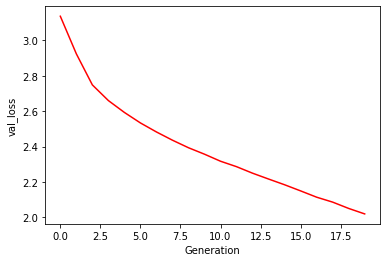

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Generation");
ax.set_ylabel("val_loss");  
ax.plot([i for i in range(len(data.history["loss"]))], data.history["loss"], color = 'red') 
plt.show()

In [30]:
# load the network weights
filename = "weights-improvement-11-2.3169.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [31]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [32]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print( "Seed:")
print( "\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print( "\nDone.")


Seed:
" ame suddenly
upon an open place, with a little house in it about four feet high.
вђњwhoever lives th "
e soee to the soee to the toee to the toee to the toee to the toee to the toee  nh   nhe  an ce in whu  nn aa in the wool  and the wost  and she tooe   nh  aa  no aa lo the wool  and the wosdd the wosdd the had not oo the tooe  nh   nhe  an ce in whu  nn aa in the wool  and the wost  and she tooe   nh  aa  no aa lo the wool  and the wosdd the wosdd the had not oo the tooe  nh   nhe  an ce in whu  nn aa in the wool  and the wost  and she tooe   nh  aa  no aa lo the wool  and the wosdd the wosdd the had not oo the tooe  nh   nhe  an ce in whu  nn aa in the wool  and the wost  and she tooe   nh  aa  no aa lo the wool  and the wosdd the wosdd the had not oo the tooe  nh   nhe  an ce in whu  nn aa in the wool  and the wost  and she tooe   nh  aa  no aa lo the wool  and the wosdd the wosdd the had not oo the tooe  nh   nhe  an ce in whu  nn aa in the wool  and the wost  and she tooe

Вывод результата генерации текста моделюь после обучения

In [ ]:
!tensorboard --logdir=./logs